In [1]:
%load_ext nb_black
from collections import Counter
from umap import UMAP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

<IPython.core.display.Javascript object>

In [2]:
# useful functions
def pca_loadings(pca):
    return pca.components_.T * np.sqrt(pca.explained_variance_)


def plot_dendrogram(model, **kwargs):
    """
    A function for plotting a dendrogram. Sourced from the following link:
    https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
    
    Parameters:
        model (object of class sklearn.cluster.hierarchical.AgglomerativeClustering): a fitted scikit-learn hierarchical clustering model.
    
    Output: a dendrogram based on the model based in the parameters.
    
    Returns: None   
    """
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0] + 2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(
        float
    )

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_csv(r"C:\Users\jonat\Desktop\Stocks\prices.csv")
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


<IPython.core.display.Javascript object>

In [4]:
# is it datetime?
display(df.info())
# Guess not, let's make it datetime
df["date"] = df["date"].str.replace("00:00:00", "")
df["date"] = pd.to_datetime(df["date"])
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    851264 non-null  datetime64[ns]
 1   symbol  851264 non-null  object        
 2   open    851264 non-null  float64       
 3   close   851264 non-null  float64       
 4   low     851264 non-null  float64       
 5   high    851264 non-null  float64       
 6   volume  851264 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 45.5+ MB


None

<IPython.core.display.Javascript object>

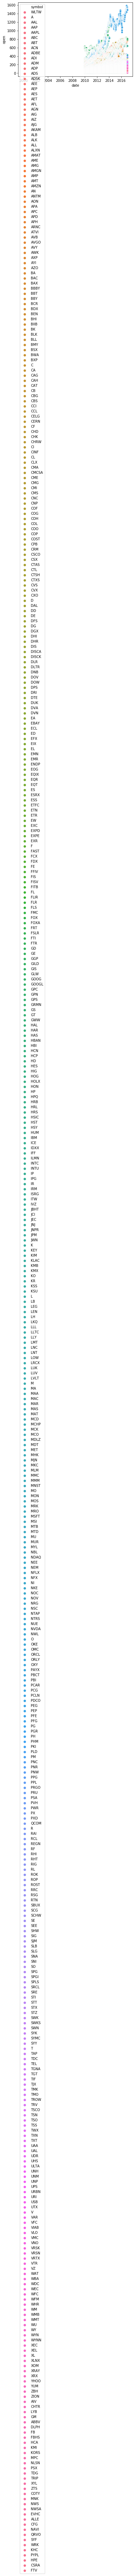

<IPython.core.display.Javascript object>

In [5]:
# That is pretty... pretty cluttered. We should prob try to clean it up a little before we do anything
sns.scatterplot(x="date", y="open", hue="symbol", data=df)

In [6]:
# Let's separate based on month, day, and year.
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
# now we drop date since it's kinda useless to us


<IPython.core.display.Javascript object>

In [7]:
# Are there any NA?
df.isna().mean()

date      0.0
symbol    0.0
open      0.0
close     0.0
low       0.0
high      0.0
volume    0.0
year      0.0
month     0.0
day       0.0
dtype: float64

<IPython.core.display.Javascript object>

In [8]:
# I want to see how many points of data we have
low_stocks = df.symbol.value_counts()
Counter(low_stocks)

Counter({1762: 467,
         1761: 1,
         1683: 1,
         1540: 1,
         1008: 13,
         987: 1,
         896: 1,
         894: 1,
         892: 2,
         853: 1,
         786: 1,
         504: 4,
         385: 1,
         378: 2,
         304: 1,
         284: 1,
         251: 1,
         126: 1})

<IPython.core.display.Javascript object>

In [9]:
# Want to deal with stocks that have full data.Create equality among data
count = 0
for i in low_stocks:
    if i == 1762:
        count += 1
    else:
        count = count

print(count)

467


<IPython.core.display.Javascript object>

In [10]:
# keeping CHTR because it's only missing one. The percentage of missing data isn't enough to warrant dropping it
to_drop = low_stocks.tail(34)
pls_work = to_drop.reset_index()
drop = pls_work["index"].values
df["symbol"] = df["symbol"].replace(drop, "NaN")
df["symbol"]

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
851259     ZBH
851260    ZION
851261     NaN
851262     AIV
851263     NaN
Name: symbol, Length: 851264, dtype: object

<IPython.core.display.Javascript object>

In [11]:
df_full = df[~df["symbol"].str.contains("NaN")]
df_full["symbol"].value_counts()

DLTR    1762
O       1762
WDC     1762
ORLY    1762
VZ      1762
        ... 
CMS     1762
ITW     1762
CBS     1762
MDLZ    1762
OKE     1762
Name: symbol, Length: 467, dtype: int64

<IPython.core.display.Javascript object>

In [12]:
df_full

,date,symbol,open,close,low,high,volume,year,month,day
251,2010-01-04,A,31.389999,31.300001,31.130000,31.630001,3815500.0,2010,1,4
252,2010-01-04,AAL,4.840000,4.770000,4.660000,4.940000,9837300.0,2010,1,4
253,2010-01-04,AAP,40.700001,40.380001,40.360001,41.040001,1701700.0,2010,1,4
254,2010-01-04,AAPL,213.429998,214.009998,212.380001,214.499996,123432400.0,2010,1,4
255,2010-01-04,ABC,26.290001,26.629999,26.139999,26.690001,2455900.0,2010,1,4
...,...,...,...,...,...,...,...,...,...,...
851257,2016-12-30,YHOO,38.720001,38.669998,38.430000,39.000000,6431600.0,2016,12,30
851258,2016-12-30,YUM,63.930000,63.330002,63.160000,63.939999,1887100.0,2016,12,30
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0,2016,12,30
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0,2016,12,30


<IPython.core.display.Javascript object>

In [13]:
df_full.columns

Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume', 'year',
       'month', 'day'],
      dtype='object')

<IPython.core.display.Javascript object>

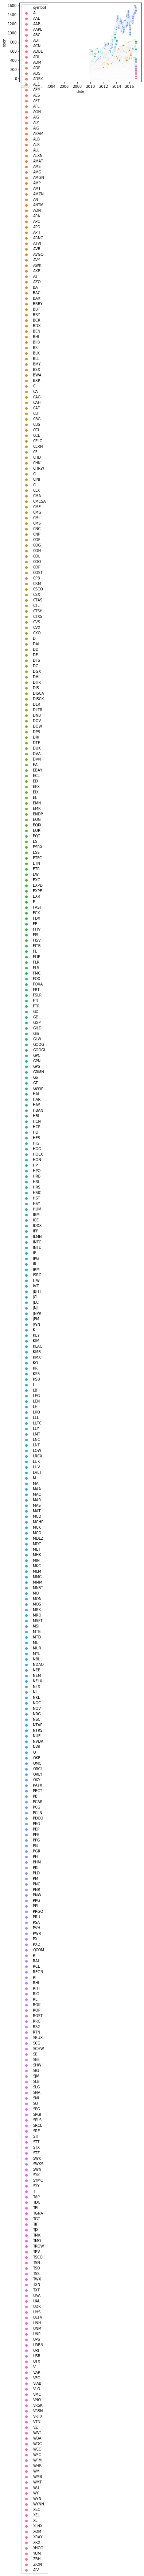

<IPython.core.display.Javascript object>

In [14]:
# Seems like there are a few groups at the end. The fact that they start similarly but end vastly different is interesting
sns.scatterplot(x="date", y="open", hue="symbol", data=df_full)

# We should probably get some more features based on amount change and change per day. These could be valuable to traders. If a stock consistantly has a big high low split, it'd be a good stock to day-trade/scalp. If the open is usually bigger than close, it'd be a good stock to hold longterm, etc.

In [15]:
# Engineer the difference rather than deal with it each time.
df_full["perc_co_dif"] = ((df_full["close"] - df_full["open"]) / df_full["close"]) * 100
df_full["perc_hl_dif"] = ((df_full["high"] - df_full["low"]) / df_full["close"]) * 100
df_full = df_full.reset_index().drop(columns="index")
# df_full

C:\Users\jonat\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jonat\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>

In [16]:
# There's decent relation between open, close, low, and high. Not too big of a shock
number = df_full.drop(columns=["symbol", "date", "year"])
# sns.pairplot(number)

<IPython.core.display.Javascript object>

# I'm going to scale the data so the wild expensive stocks don't weigh things down too much

In [17]:
scaler = StandardScaler()
scaled = scaler.fit_transform(number)

k_means = KMeans(n_clusters=6, random_state=69)
k_means.fit(scaled)
y_pred = k_means.predict(scaled)

<IPython.core.display.Javascript object>

In [18]:
columns = number.columns
centroids = scaler.inverse_transform(k_means.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=number.columns)
centroids_df

,open,close,low,high,volume,month,day,perc_co_dif,perc_hl_dif
0,56.902170,56.905230,56.429895,57.359261,3.927554e+06,9.569649,16.001503,-0.000663,1.673747
1,56.086915,56.115779,55.621292,56.554982,4.242318e+06,3.482716,15.647461,0.046025,1.694315
2,201.905924,201.966246,199.899703,203.887601,3.086673e+06,6.753377,15.762467,0.023471,1.923318
3,45.070766,46.292927,44.726417,46.639956,8.884185e+06,6.627634,15.088667,2.578858,4.119898
4,44.230220,43.026287,42.637804,44.543647,1.597298e+07,6.458118,15.134783,-2.660568,4.363764
5,680.214531,680.095832,673.567041,686.390133,9.523682e+06,6.611924,15.736078,-0.025377,1.927275


<IPython.core.display.Javascript object>

In [19]:
number["label6"] = k_means.labels_
# sns.pairplot(number, hue="label6")
# plt.show()

<IPython.core.display.Javascript object>

In [20]:
# # Now let's look at 4 to see if those two need to be in there
number4 = number.drop(columns="label6")
number4.columns
# sns.pairplot(number4, hue="label4")

Index(['open', 'close', 'low', 'high', 'volume', 'month', 'day', 'perc_co_dif',
       'perc_hl_dif'],
      dtype='object')

<IPython.core.display.Javascript object>

In [21]:
k_means_4 = KMeans(n_clusters=4, random_state=69)
k_means_4.fit(scaled)
y_pred = k_means_4.predict(scaled)
centroids_4 = scaler.inverse_transform(k_means_4.cluster_centers_)
number["label4"] = k_means_4.labels_

<IPython.core.display.Javascript object>

In [22]:
k_means_5 = KMeans(n_clusters=5, random_state=69)
k_means_5.fit(scaled)
y_pred = k_means_5.predict(scaled)
centroids_5 = scaler.inverse_transform(k_means_5.cluster_centers_)
number["label5"] = k_means_5.labels_

<IPython.core.display.Javascript object>

In [23]:
#
sampled = number.copy()
sample = sampled.sample(n=12345, random_state=69)
sample

,open,close,low,high,volume,month,day,perc_co_dif,perc_hl_dif,label6,label4,label5
356109,22.440001,22.360001,22.180000,22.719999,1201400.0,1,14,-0.357782,2.415022,1,1,4
801647,60.529999,60.549999,60.110001,60.759998,1552000.0,10,26,0.033031,1.073488,0,3,1
600505,40.709999,40.230000,40.049999,40.880001,2928400.0,2,11,-1.193137,2.063142,1,1,4
506341,132.529999,128.699997,128.020004,133.080002,1224500.0,4,25,-2.975915,3.931622,4,0,3
663406,45.720001,43.150002,43.009998,45.720001,4786500.0,8,25,-5.955965,6.280424,4,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
385512,18.240000,18.139999,17.910000,18.340000,5709500.0,4,16,-0.551273,2.370452,1,1,4
343432,12.220000,12.220000,12.100000,12.380000,19057200.0,12,4,0.000000,2.291326,0,3,1
549130,54.560001,54.160000,54.119999,54.680000,473400.0,9,4,-0.738554,1.033975,0,3,1
752250,62.849998,62.669998,62.369999,63.360001,978500.0,5,26,-0.287219,1.579706,1,1,4


<IPython.core.display.Javascript object>

In [24]:
# Trying hierarchical for comparison
dist_mat = squareform(pdist(sample, metric="euclid"))
clst = AgglomerativeClustering(n_clusters=5, linkage="ward", affinity="euclidean")
clst.fit(sample)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5)

<IPython.core.display.Javascript object>

In [25]:
# That's pretty useless imo
# plt.figure(figsize=(20, 10))
# plot_dendrogram(clst)

<IPython.core.display.Javascript object>

In [26]:
# Well... These clusters seem like they're not grouped well. Let's check value counts
sample["label"] = clst.labels_
sample.groupby("label").mean()

,open,close,low,high,volume,month,day,perc_co_dif,perc_hl_dif,label6,label4,label5
label,,,,,,,,,,,,
0,80.959999,80.327647,79.824705,81.830588,2.176055e+08,5.294118,13.705882,-0.241653,3.684787,4.117647,1.294118,2.882353
1,85.686270,85.904206,84.911667,86.742699,7.602710e+07,6.753968,15.674603,0.093762,3.129382,3.230159,1.841270,2.603175
2,52.747389,52.754880,52.098039,53.373354,7.984637e+06,6.370177,15.612997,0.011644,2.477030,1.322599,1.908036,2.532057
3,37.781529,37.746588,37.214682,38.302164,2.939342e+07,5.962353,15.764706,-0.239691,2.904883,1.821176,1.783529,2.762353
4,79.523441,79.558330,78.782334,80.257003,1.787606e+06,6.608163,15.961945,0.027096,1.891972,0.957023,1.796158,2.266387


<IPython.core.display.Javascript object>

In [27]:
sample["label"].value_counts()

4    8330
2    3447
3     425
1     126
0      17
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [28]:
number["label6"].value_counts()

0    313493
1    312251
3     67949
4     65126
2     54881
5      9154
Name: label6, dtype: int64

<IPython.core.display.Javascript object>

In [29]:
number["label4"].value_counts()

3    374836
1    370518
0     68100
2      9400
Name: label4, dtype: int64

<IPython.core.display.Javascript object>

In [30]:
number["label5"].value_counts()

1    344816
4    340059
3     69327
0     59414
2      9238
Name: label5, dtype: int64

<IPython.core.display.Javascript object>

In [31]:
sample.groupby("label").mean()

,open,close,low,high,volume,month,day,perc_co_dif,perc_hl_dif,label6,label4,label5
label,,,,,,,,,,,,
0,80.959999,80.327647,79.824705,81.830588,2.176055e+08,5.294118,13.705882,-0.241653,3.684787,4.117647,1.294118,2.882353
1,85.686270,85.904206,84.911667,86.742699,7.602710e+07,6.753968,15.674603,0.093762,3.129382,3.230159,1.841270,2.603175
2,52.747389,52.754880,52.098039,53.373354,7.984637e+06,6.370177,15.612997,0.011644,2.477030,1.322599,1.908036,2.532057
3,37.781529,37.746588,37.214682,38.302164,2.939342e+07,5.962353,15.764706,-0.239691,2.904883,1.821176,1.783529,2.762353
4,79.523441,79.558330,78.782334,80.257003,1.787606e+06,6.608163,15.961945,0.027096,1.891972,0.957023,1.796158,2.266387


<IPython.core.display.Javascript object>

In [32]:
number.groupby("label6").mean().drop(columns=["label4", "label5"])

,open,close,low,high,volume,month,day,perc_co_dif,perc_hl_dif
label6,,,,,,,,,
0,56.919097,56.922130,56.446680,57.376300,3.926965e+06,9.569544,16.001573,-0.000732,1.673647
1,56.104746,56.133656,55.639017,56.572948,4.241125e+06,3.482846,15.647377,0.046068,1.694211
2,202.088773,202.148677,200.080007,204.072562,3.090420e+06,6.753357,15.764272,0.023115,1.924014
3,45.070458,46.292398,44.726102,46.639393,8.882122e+06,6.628295,15.088066,2.578319,4.119407
4,44.222696,43.019017,42.630614,44.536082,1.597395e+07,6.458020,15.134340,-2.660256,4.363371
5,680.319356,680.200566,673.670741,686.495840,9.523962e+06,6.613284,15.736290,-0.025397,1.927301


<IPython.core.display.Javascript object>

In [33]:
number.groupby("label4").mean().drop(columns=["label6", "label5"])

,open,close,low,high,volume,month,day,perc_co_dif,perc_hl_dif
label4,,,,,,,,,
0,187.248634,187.297009,185.348653,189.116361,3.190184e+06,6.762085,15.829927,0.018641,1.962505
1,52.792857,52.817390,52.261233,53.321687,5.875029e+06,3.522363,15.558289,0.029565,2.120191
2,673.877307,673.758788,667.276001,680.011964,9.704860e+06,6.586915,15.708830,-0.025596,1.933679
3,53.294605,53.309402,52.752245,53.831256,5.257576e+06,9.503177,15.825721,0.013740,2.143915


<IPython.core.display.Javascript object>

In [34]:
number.groupby("label5").mean().drop(columns=["label6", "label4"])

,open,close,low,high,volume,month,day,perc_co_dif,perc_hl_dif
label5,,,,,,,,,
0,196.477600,196.589565,194.529299,198.459182,2.964228e+06,6.764130,15.784563,0.054312,1.953655
1,55.391958,55.505033,54.935434,55.943933,4.159932e+06,9.534357,15.902075,0.234272,1.886657
2,678.102530,677.986649,671.474123,684.264609,9.618027e+06,6.600779,15.729270,-0.024780,1.928541
3,42.431690,41.431078,40.930042,42.864725,1.792963e+07,6.474245,15.194801,-2.178208,4.593350
4,54.825758,54.948132,54.375242,55.375501,4.451061e+06,3.500410,15.592959,0.248085,1.876514


<IPython.core.display.Javascript object>

# Now let's check dimension reduction techniques to see if they are helpful at all for better distinguishing clusters

In [35]:
pca = PCA(n_components=6)
pca_df_full = pca.fit_transform(scaled)
loadings = pca_loadings(pca)
loadings = pd.DataFrame(loadings)
loadings.index = columns
loadings.columns = [f"component_{i}" for i in range(loadings.shape[1])]

<IPython.core.display.Javascript object>

In [36]:
pca5 = PCA(n_components=5)
pca5_df = pca5.fit_transform(scaled)
loadings5 = pca_loadings(pca5)
loadings5 = pd.DataFrame(loadings5)
loadings5.index = columns
loadings5.columns = [f"component_{i}" for i in range(loadings5.shape[1])]

<IPython.core.display.Javascript object>

In [37]:
# Interesting. Stocks seem to be more expensive at vertain parts of the year. The month can also cheapen a stock
loadings

,component_0,component_1,component_2,component_3,component_4,component_5
open,0.999287,0.036651,-0.002660,0.003512,0.002307,-0.002479
close,0.999312,0.033359,-0.009507,0.003194,0.009760,-0.004339
low,0.999446,0.031437,-0.005999,0.003590,0.005778,-0.000170
high,0.999191,0.038100,-0.006177,0.003176,0.006544,-0.006411
volume,-0.085697,0.710546,-0.111599,0.094846,0.336768,0.594069
month,0.022308,-0.095972,0.614592,-0.611189,0.488546,0.018451
day,0.004262,-0.123489,0.471681,0.785310,0.367226,-0.103359
perc_co_dif,0.001552,-0.312708,-0.631702,-0.025123,0.689712,-0.163803
perc_hl_dif,-0.100323,0.751621,-0.000229,-0.049756,0.090183,-0.643734


<IPython.core.display.Javascript object>

In [38]:
loadings5

,component_0,component_1,component_2,component_3,component_4
open,0.999287,0.036651,-0.002660,0.003512,0.002307
close,0.999312,0.033359,-0.009507,0.003194,0.009760
low,0.999446,0.031437,-0.005999,0.003590,0.005778
high,0.999191,0.038100,-0.006177,0.003176,0.006544
volume,-0.085697,0.710546,-0.111599,0.094846,0.336768
month,0.022308,-0.095972,0.614592,-0.611189,0.488546
day,0.004262,-0.123489,0.471681,0.785310,0.367226
perc_co_dif,0.001552,-0.312708,-0.631702,-0.025123,0.689712
perc_hl_dif,-0.100323,0.751621,-0.000229,-0.049756,0.090183


<IPython.core.display.Javascript object>

# Let's check on UMAP to see if it does anything PCA doesn't

In [39]:
# Let's see if another method would be better for dimensionality reduction. UMAP TIME!
# if i put in all of scaled, it can't deal with it. Time to random sample
umap = UMAP(n_neighbors=6, min_dist=0.3, metric="euclidean")
umap_fit = umap.fit_transform(sample)

C:\Users\jonat\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


<IPython.core.display.Javascript object>

In [40]:
umap_fit

array([[-0.32391337, 16.230753  ],
       [10.692502  ,  1.8233569 ],
       [ 1.378688  , -8.496283  ],
       ...,
       [ 8.047789  ,  9.316154  ],
       [ 9.603347  ,  4.324859  ],
       [-7.0104213 ,  5.8141484 ]], dtype=float32)

<IPython.core.display.Javascript object>

In [41]:
umap_df = pd.DataFrame(umap_fit, index=sample.index)

<IPython.core.display.Javascript object>

In [42]:
umap = UMAP(n_neighbors=6, min_dist=0.6, metric="euclidean")
umap_fit = umap.fit_transform(sample)
umap_df = pd.DataFrame(umap_fit, index=sample.index)


# Due to github data restraints, this like is being commented out. To see the plot, uncomment the below line.
# px.scatter(umap_df, x=umap_fit[:, 0], y=umap_fit[:, 1])

C:\Users\jonat\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


<IPython.core.display.Javascript object>

In [43]:
umap = UMAP(n_neighbors=5, min_dist=0.6, metric="euclidean")
feeling_like_will = umap.fit_transform(sample)
umap_df = pd.DataFrame(feeling_like_will, index=sample.index)


# Due to github data restraints, this like is being commented out. To see the plot, uncomment the below line.
# px.scatter(umap_df, x=feeling_like_will[:, 0], y=feeling_like_will[:, 1])

C:\Users\jonat\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


<IPython.core.display.Javascript object>

# These don't really look like they add much information so I'm just going to look at the clustered data. It seems like 6 neighbors has better information for stock traders as I will explain below. As a reminder, here is the mean of that group and the scatterplot

In [44]:
number = number.drop(columns=["label4", "label5"])

<IPython.core.display.Javascript object>

In [45]:
number["label6"].value_counts()

0    313493
1    312251
3     67949
4     65126
2     54881
5      9154
Name: label6, dtype: int64

<IPython.core.display.Javascript object>

In [46]:
number.groupby("label6").mean()

,open,close,low,high,volume,month,day,perc_co_dif,perc_hl_dif
label6,,,,,,,,,
0,56.919097,56.922130,56.446680,57.376300,3.926965e+06,9.569544,16.001573,-0.000732,1.673647
1,56.104746,56.133656,55.639017,56.572948,4.241125e+06,3.482846,15.647377,0.046068,1.694211
2,202.088773,202.148677,200.080007,204.072562,3.090420e+06,6.753357,15.764272,0.023115,1.924014
3,45.070458,46.292398,44.726102,46.639393,8.882122e+06,6.628295,15.088066,2.578319,4.119407
4,44.222696,43.019017,42.630614,44.536082,1.597395e+07,6.458020,15.134340,-2.660256,4.363371
5,680.319356,680.200566,673.670741,686.495840,9.523962e+06,6.613284,15.736290,-0.025397,1.927301


<IPython.core.display.Javascript object>

# This is all good and well, but the stocks are grouped based on day. Theoretically, one ticker could be in multiple labels. These stocks should be grouped based on which label they appear in the most! 

In [47]:
number["ticker"] = df_full["symbol"]
number["date"] = df_full["date"]
number

,open,close,low,high,volume,month,day,perc_co_dif,perc_hl_dif,label6,ticker,date
0,31.389999,31.300001,31.130000,31.630001,3815500.0,1,4,-0.287534,1.597447,1,A,2010-01-04
1,4.840000,4.770000,4.660000,4.940000,9837300.0,1,4,-1.467505,5.870021,4,AAL,2010-01-04
2,40.700001,40.380001,40.360001,41.040001,1701700.0,1,4,-0.792472,1.684002,1,AAP,2010-01-04
3,213.429998,214.009998,212.380001,214.499996,123432400.0,1,4,0.271015,0.990606,2,AAPL,2010-01-04
4,26.290001,26.629999,26.139999,26.690001,2455900.0,1,4,1.276748,2.065347,1,ABC,2010-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...
822849,38.720001,38.669998,38.430000,39.000000,6431600.0,12,30,-0.129307,1.474011,0,YHOO,2016-12-30
822850,63.930000,63.330002,63.160000,63.939999,1887100.0,12,30,-0.947415,1.231642,0,YUM,2016-12-30
822851,103.309998,103.199997,102.849998,103.930000,973800.0,12,30,-0.106590,1.046514,0,ZBH,2016-12-30
822852,43.070000,43.040001,42.689999,43.310001,1938100.0,12,30,-0.069700,1.440525,0,ZION,2016-12-30


<IPython.core.display.Javascript object>

In [48]:
test = number.copy()

<IPython.core.display.Javascript object>

In [49]:
# get all my tickers in one place
tickers = test["ticker"].unique().tolist()

for ticker in tickers:
    looking = test[test["ticker"] == ticker]
    counts = looking["label6"].value_counts().nlargest(n=1)
    x = int(counts.index.tolist()[0])
    test.loc[test["ticker"] == ticker, ["label6"]] = x

<IPython.core.display.Javascript object>

In [50]:
test[test["ticker"] == "A"]["label6"].unique()

array([1])

<IPython.core.display.Javascript object>

In [51]:
test.groupby("label6").mean()

,open,close,low,high,volume,month,day,perc_co_dif,perc_hl_dif
label6,,,,,,,,,
0,50.850639,50.868141,50.350248,51.346107,5.433300e+06,6.549943,15.704313,0.022036,2.084471
1,62.050026,62.072760,61.444344,62.649350,4.042037e+06,6.549943,15.704313,0.024877,2.063078
2,169.798120,169.850875,167.973377,171.602963,2.663074e+06,6.549943,15.704313,0.033834,2.232219
3,36.620732,36.624126,35.996016,37.264552,6.014288e+06,6.549943,15.704313,-0.015513,3.677522
4,27.065255,27.032350,26.594340,27.494690,3.984891e+07,6.549943,15.704313,-0.156137,3.496931
5,596.438817,596.334879,590.467370,601.980359,2.073368e+07,6.549943,15.704313,-0.022956,2.006801


<IPython.core.display.Javascript object>

# Analysis of the clusters:

# Cluster Names:
- Cluster 0 = Middle cluster
- Cluster 1 = Stable and cheap
- Cluster 2 = Expensive Middle
- Cluster 3 = Knowlingly Risky
- Cluster 4 = Loose Cannon
- Cluster 5 = Benjamin Button

# General: Clusters 2 , and 5 seem to be similar in terms of Difference metrics while acting as the two with most expensive stock prices. Ideally, it seems cluster 3 would be the one to day trade among all of these and other people recognize that given it's the most volume traded cluster.


- open: Benjamin Button is very expensive but the loose cannon is cheap (that's why it's loose).
- close, low, and high: same as abive
- volume: This is interesting, it seems most trading is done on biggest high low percentage split stocks(Knowingly risky) by far. The lowest difference also has the least volume
- month and day: The mean is 15. It means nothing.
- perc_hl_dif: This is interesting. The biggest difference on group 3 which could explain the reason for trading volume. Given the open amount of the stock, it makes sense there's a bigger dollar value would have a bigger high/low split. The second highest seems cheaper. There could be something with these stocks to explain their seemingly similar volitility but lack of trading volume.
- perc_co_dif: These offer very little benefit to the overall clustering


In [59]:
# Want to remind myself of column names so I format the queries correctly
centroids_df.columns

Index(['open', 'close', 'low', 'high', 'volume', 'month', 'day', 'perc_co_dif',
       'perc_hl_dif'],
      dtype='object')

<IPython.core.display.Javascript object>

In [54]:
# format is 'open', 'close', 'low', 'high', 'volume','month', 'day','perc_co_dif', 'perc_hl_dif'
chegg = [[62.34, 62.93, 61.67, 63.34, 2725077, 5, 20, -0.93, 2.65]]
apple = [[316.68, 319.16, 316.2, 319.52, 50980000, 5, 20, .77, 1.04]]
cars = [[1116.37, 1114.49, 1105.02, 1142.99, 289208, 5, 20, -0.16, 3.41]]
search = [[1389.16, 1409.18, 1365, 1420, 1864967, 5, 20, 1.42, 3.90]]

thinkful = k_means.predict(scaler.transform(chegg))
pomme = k_means.predict(scaler.transform(apple))
auto_zone = k_means.predict(scaler.transform(cars))
google = k_means.predict(scaler.transform(search))


<IPython.core.display.Javascript object>

In [55]:
print(thinkful)

[1]


<IPython.core.display.Javascript object>

In [56]:
print(pomme)

[2]


<IPython.core.display.Javascript object>

In [57]:
print(auto_zone)

[5]


<IPython.core.display.Javascript object>

In [58]:
print(google)

[5]


<IPython.core.display.Javascript object>